In [2]:
import sys

from episodic_memory.utils.all_imports import *
from decouple import config  # obtain environment files

from scipy.spatial import distance
from scipy.optimize import approx_fprime

import argparse
import os
import numpy as np

# sys.path.append('/media/arjun/Shared/research_projects/episodic_hopfield/python_modules')

from episodic_memory.experiment import temporal_pattern_from_output, find_best_chain_length, \
    pattern_changes_from_temporal_pattern
from episodic_memory.experiment import train_episodic_network
from episodic_memory.utils import normalize
from episodic_memory.networks.AdiabaticEpisodicExp import AdiabaticEpisodicExponential
from bokeh.models import Range1d
from episodic_memory.utils import add_experiment_id

from episodic_memory.plotting import quick_plot
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA

import matplotlib.animation as animation
import matplotlib.pyplot as plt

from IPython.display import clear_output

ModuleNotFoundError: No module named 'ipympl'

In [ ]:
N = 100
SEED = 0
N_PATTERNS = 20
T_d = 20
BETA_D = 1.0
ALPHA_S = 1.0
ALPHA_C = 0.991
OUTPUT_SUBSECTION = 100

PATTERN_ORDER = [1, 2, 3, 4]
CUE_ID = PATTERN_ORDER[-1] - 1

EXPERIMENT_ID = 356
TEST_DURATION = 1.5

OUTPUT_DIR = os.path.join(config('EXPERIMENT_OUTPUT_DIR'), "reconsolidation_v13")

In [3]:
mnet = AdiabaticEpisodicExponential()
mnet.initialize(seed=SEED,
                T_d=T_d,
                alpha_s=ALPHA_S,
                alpha_c=ALPHA_C,
                beta_d=BETA_D,
                N=N,
                n_patterns=N_PATTERNS,
                approximation="range-kutta")

np.random.seed(SEED)

# create patterns
n_patterns = N_PATTERNS
patterns = mnet.xi[:OUTPUT_SUBSECTION, :].T.copy()
patterns = patterns / np.linalg.norm(patterns, axis=1).reshape((-1, 1))

# Learning method
mnet_test = copy.deepcopy(mnet)  # mnet_test is the one that changes with learning

## Step 1: Initialize network synapses
xi0 = np.random.normal(size=mnet.xi.shape)
phi0 = np.random.normal(size=mnet.phi.shape)

## Load learned paraemeters
with open(os.path.join(OUTPUT_DIR, "final", add_experiment_id("params_xi.pkl", EXPERIMENT_ID)), 'rb') as f:
    xi = pkl.load(f)

with open(os.path.join(OUTPUT_DIR, "final", add_experiment_id("params_phi.pkl", EXPERIMENT_ID)), 'rb') as f:
    phi = pkl.load(f)

with open(os.path.join(OUTPUT_DIR, "final", add_experiment_id("params_w_ih.pkl", EXPERIMENT_ID)), 'rb') as f:
    W_ih = pkl.load(f)

with open(os.path.join(OUTPUT_DIR, "final", add_experiment_id("params_w_hh.pkl", EXPERIMENT_ID)), 'rb') as f:
    W_ho = pkl.load(f)
    
# with open(os.path.join(OUTPUT_DIR, "final", add_experiment_id("state_v_d.pkl", EXPERIMENT_ID)), 'rb') as f:
#     mnet_test.v_d = pkl.load(f)

print("xi range: ", np.min(xi), np.max(xi))
print("phi range: ", np.min(phi), np.max(phi))
print("W_ih range: ", np.min(W_ih), np.max(W_ih))
print("W_ho range: ", np.min(W_ho), np.max(W_ho))

xi range:  -5.000003651880819 5.0000036507529675
phi range:  -0.8942551443619187 1.3857401938028768
W_ih range:  0.0 1.0
W_ho range:  0.0 1.0


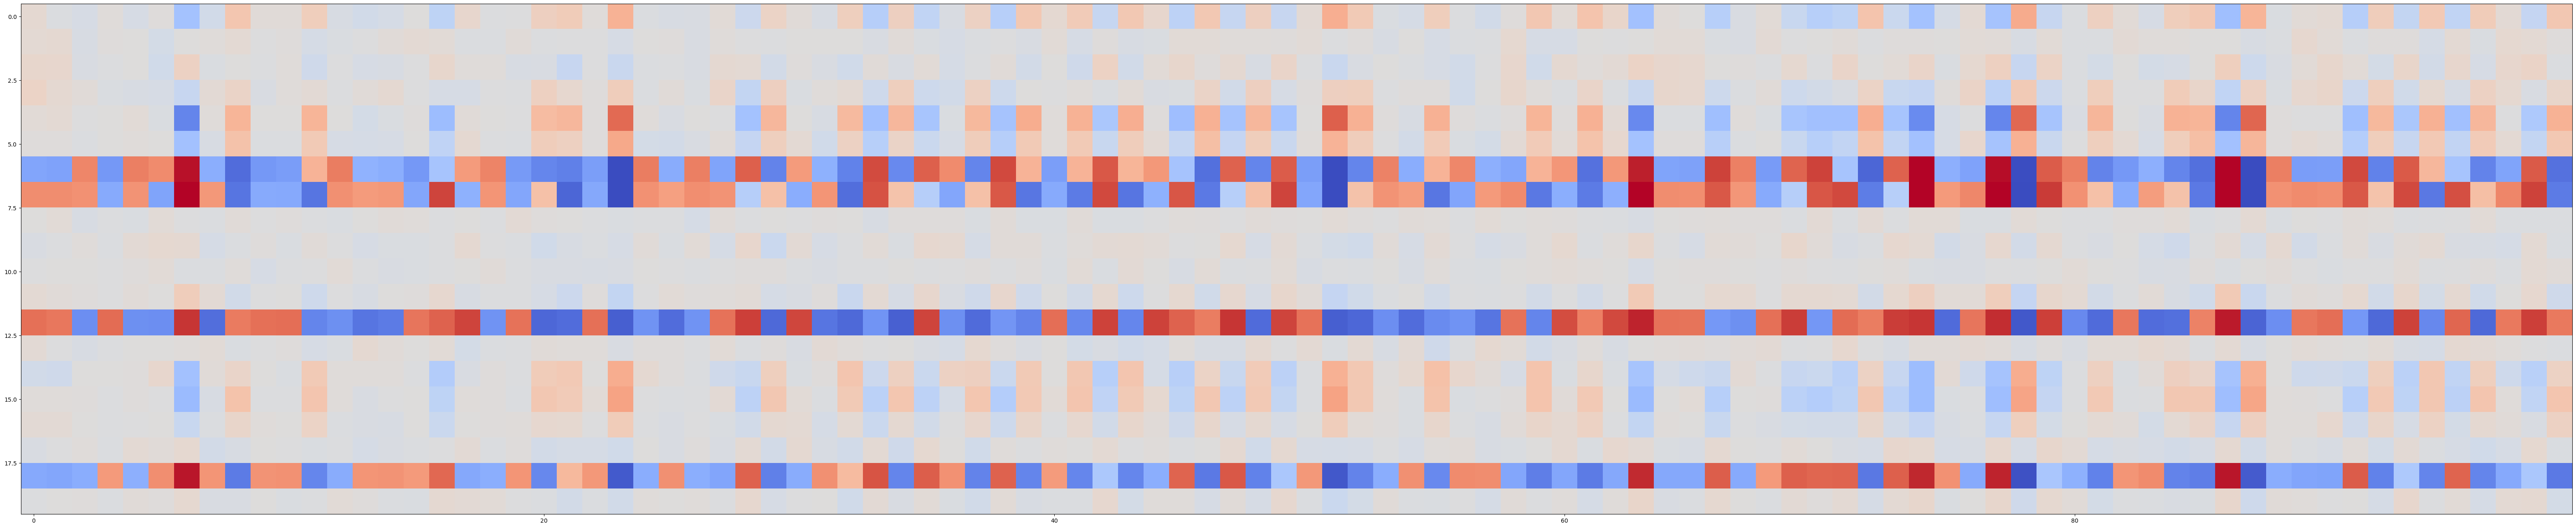

In [4]:
fig = plt.figure(figsize=(80, 40))
plt.clf()
plt.imshow(xi.T, cmap="coolwarm")
plt.close()

display(fig)
# plt.close()

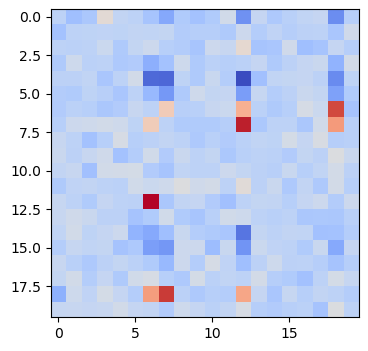

In [5]:
fig = plt.figure(figsize=(4, 4))
plt.clf()
plt.imshow(phi.T, cmap="coolwarm")
plt.close()

display(fig)
# plt.close()

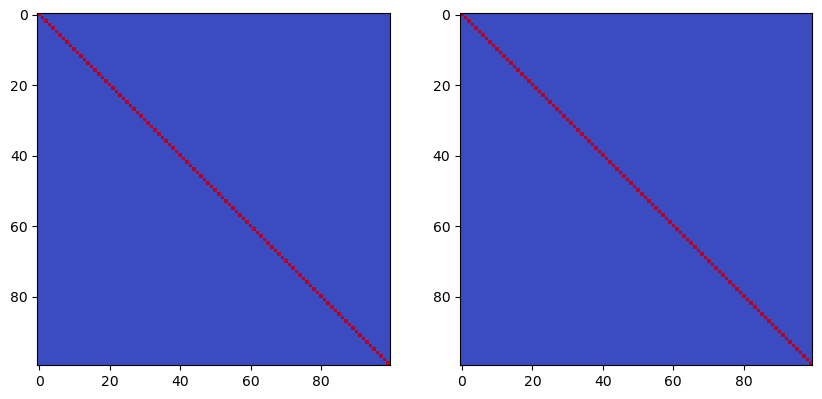

In [6]:
fig = plt.figure(figsize=(10, 8))
plt.clf()

plt.subplot(121)
plt.imshow(W_ih.T, cmap="coolwarm")

plt.subplot(122)
plt.imshow(W_ho, cmap="coolwarm")

plt.close()

display(fig)

In [7]:
## Step 3: Perform test of the learned weights
# test network
mnet_test.xi = xi
mnet_test.phi = phi

# mnet_test.alpha_c = 0.0

# plt.clf()
# plt.imshow(mnet_test.xi.T, cmap="coolwarm")
# plt.show()

simulated = []
energy_trajectory = []

mnet_test.v = np.zeros(mnet_test.v.shape)  # reset the feature neurons
# cue = np.zeros(mnet_test.v.shape)
cue = patterns[CUE_ID, :].astype('float').copy()

# cue[:int(0.0 * OUTPUT_SUBSECTION)] = 0  # removing part to test pattern completion

################### PRELOADING

i_signal = (W_ih.T @ cue).flatten()

# # option 1: directly setting cue
# mnet_test.v = i_signal

# mnet_test.v_d = i_signal

# # option 2: warm starting
# # warm starting
for i in range(200):
    mnet_test.update(i_signal)

################### END PRELOADING
model_output = mnet_test.v.reshape((-1, 1))
model_output_vd = mnet_test.v_d.reshape((-1, 1))

simulated.append((np.clip((model_output.T @ W_ho).flatten(), -1, 1), mnet_test.get_energy(),
                                      np.clip((model_output_vd.T @ W_ho).flatten(), -1, 1)))
diag_freq = 10

print("Testing")
for i in tqdm(range(int(TEST_DURATION * n_patterns * 10000) // 6)):
    mnet_test.update()

    if i < 100:
        per = diag_freq
    else:
        per = diag_freq
    
    mnet_test.v = np.clip(mnet_test.v, -1, 1)
    
    if i % per == 0:
        model_output = mnet_test.v.reshape((-1, 1))
        model_output_vd = mnet_test.v_d.reshape((-1, 1))

        simulated.append((np.clip((model_output.T @ W_ho).flatten(), -1, 1), mnet_test.get_energy(),
                          np.clip((model_output_vd.T @ W_ho).flatten(), -1, 1)))

Testing


  0%|          | 0/50000 [00:00<?, ?it/s]

[ 6 12 18  7 17  9 19  1 10 13 16  8  2  3  5 11 14  0 15  4]


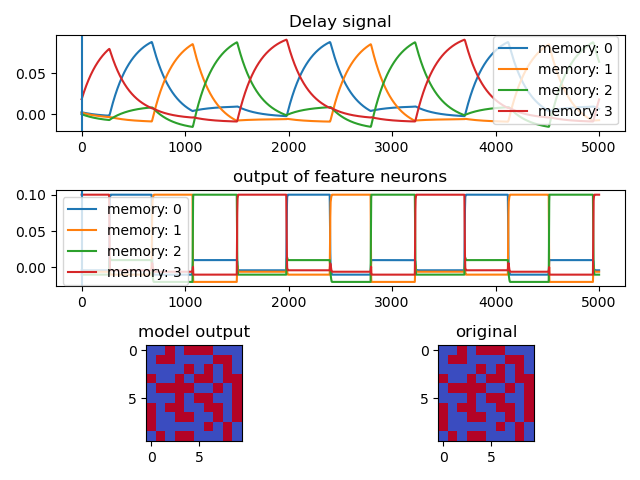

In [11]:
## Step 4: Save plots of output
pattern_correlations_test = np.array([var[0][:OUTPUT_SUBSECTION] for var in simulated]) @ patterns.T \
                            / OUTPUT_SUBSECTION

pattern_corr_vd = np.array([var[2][:OUTPUT_SUBSECTION] for var in simulated]) @ patterns.T \
                  / OUTPUT_SUBSECTION

plt.clf()

fig = plt.figure()
ax1 = fig.add_subplot(311)
plt.title("Delay signal")
print(np.argsort(mnet_test.h)[::-1])
for pattern_id in np.unique(PATTERN_ORDER) - 1:
    plt.plot(pattern_corr_vd[:, pattern_id], label="memory: {}".format(pattern_id))
plt.legend()

ax2 = fig.add_subplot(312)
plt.title("output of feature neurons")
for pattern_id in np.unique(PATTERN_ORDER) - 1:
    ax2.plot(pattern_correlations_test[:, pattern_id], label="memory: {}".format(pattern_id))

line1 = ax1.axvline(x=0)
line2 = ax2.axvline(x=0)
plt.legend()

ax3 = fig.add_subplot(325)
plt.title("model output")
output_state = plt.imshow(simulated[0][0][:OUTPUT_SUBSECTION].reshape((int(np.sqrt(OUTPUT_SUBSECTION)),
                                                                        int(np.sqrt(OUTPUT_SUBSECTION)))),
                          cmap="coolwarm",
                          # vmax=1, vmin=-1,
                         )

ax4 = fig.add_subplot(326)
plt.title("original")
original_pattern = plt.imshow(
    patterns[CUE_ID].reshape((int(np.sqrt(OUTPUT_SUBSECTION)), int(np.sqrt(OUTPUT_SUBSECTION)))),
    cmap="coolwarm")


def animate(i):
    # show time
    line1.set_xdta([i, i])
    line2.set_xdta([i, i])

    output_state.set_data(simulated[i][0][:OUTPUT_SUBSECTION].reshape((int(np.sqrt(OUTPUT_SUBSECTION)),
                                                                       int(np.sqrt(OUTPUT_SUBSECTION)))))
    orig_id = np.argmax((simulated[i][0][:OUTPUT_SUBSECTION].reshape((1, -1)) @ patterns.T).flatten())
    original_pattern.set_data(patterns[orig_id].reshape((int(np.sqrt(OUTPUT_SUBSECTION)),
                                                         int(np.sqrt(OUTPUT_SUBSECTION)))))
    # print("animate : {}".format(i))
    return line1, line2, output_state, original_pattern


ani = animation.FuncAnimation(fig, animate,
                              frames=len(pattern_corr_vd[:, 0]),
                              interval=20, blit=True, repeat=True)

plt.tight_layout()

# FFwriter = animation.FFMpegWriter(fps=60)
# ani.save('/media/arjun/Shared/tmp/animation.mp4', writer=FFwriter)
plt.show()
# plt.close()

# display(fig)


# plt.close()
# HTML(ani.to_html5_video())

In [20]:
COLORS = list(all_palettes['Dark2'][8][3:])

In [23]:
plt.close()

In [56]:
output_notebook()

pattern_correlations_test = np.array([np.clip(var[0][:OUTPUT_SUBSECTION], -1, 1) for var in simulated]) @ patterns.T * 10\
                            / OUTPUT_SUBSECTION
                                  
fig=None
 
legend_it = []

plot_options = dict(width=800,
                    plot_height=350,
                    tools="pan,reset,save,xwheel_zoom")

fig = figure(**plot_options)

# for pattern_id in range(min(len(COLORS), len(patterns))):
for pattern_id in range(len(PATTERN_ORDER)):
    fig, line_glyph = quick_plot.plot_line(np.array(range(0, diag_freq*pattern_correlations_test.shape[0], diag_freq))/1e3,
                                pattern_correlations_test[:, pattern_id],
                                tools=["xwheel_zoom"],
                                fig=fig,
                                line_width=4,
                                # legend_label="memory: {}".format(pattern_id + 1),
                                color=COLORS[pattern_id % len(COLORS)])
    legend_it.append(("memory: {}".format(pattern_id + 1), [ line_glyph ]))
    # fig = quick_plot.plot_line(normalize([ var[1] for var in simulated ]),
    #                            tools=["xwheel_zoom"],
    #                            fig=fig,
    #                            legend_label="energy",
    #                            color="black")

legend = Legend(items=legend_it)
legend.click_policy="hide"

fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None
# fig.xaxis.axis_label = 'whatever'
fig.xaxis.major_label_text_font_size = "15pt"
fig.yaxis.major_label_text_font_size = "15pt"
fig.yaxis[0].ticker.desired_num_ticks = 6
fig.xaxis[0].ticker.desired_num_ticks = 5

fig.add_layout(legend, "right")
fig.output_backend = "svg"

show(fig)

Loading BokehJS ...

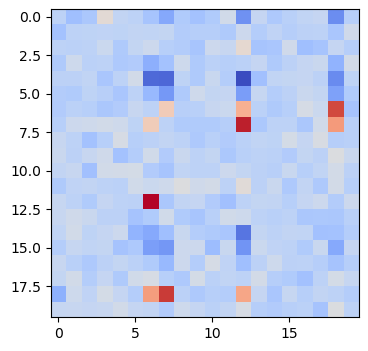

In [29]:
fig = plt.figure(figsize=(4, 4))
plt.clf()
plt.imshow(phi.T, cmap="coolwarm")

fig.savefig("phi.svg", format="svg", dpi=1200)

plt.close()
display(fig)

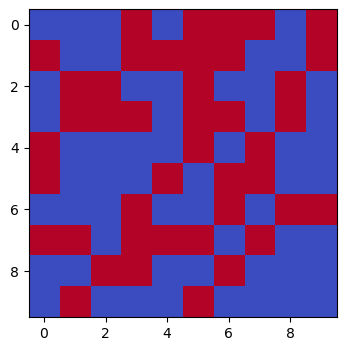

In [36]:
filter_id = 18

fig = plt.figure(figsize=(4, 4))
plt.clf()
plt.imshow(np.clip(mnet_test.xi[:, filter_id].reshape((10, 10)), -1, 1), cmap="coolwarm")

fig.savefig("xi_{}.svg".format(filter_id), format="svg", dpi=1200)

plt.close()
display(fig)

{0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: '10', 10: '11', 11: '12', 12: '13', 13: '14', 14: '15', 15: '16', 16: '17', 17: '18', 18: '19', 19: '20'}


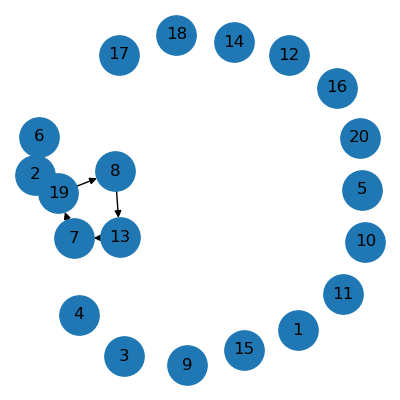

In [54]:
import networkx as nx

plt.clf()

def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.DiGraph()
    gr.add_edges_from(edges)
    print(mylabels)
    pos = nx.spring_layout(gr, k=1.0, iterations=80)
    nx.draw(gr, pos, node_size=800, labels=mylabels, with_labels=True)
    plt.show()

edge_tol = 0.6
G = np.zeros(phi.shape)

for i in range(5,20):
    indices = np.argsort(phi[:, i])[::-1][:1]
    indices = indices[phi[:, i][indices] > edge_tol]
    G[i, indices] = 1

np.fill_diagonal(G, 1)

# plt.imshow(G)
# plt.show()
show_graph_with_labels(G, {val: str(val+1) for val in range(phi.shape[0])})